In [1]:
%config Completer.use_jedi = False

In [2]:
%%configure -f
{
    "conf": {
           "spark.pyspark.python": "python3",
           "spark.pyspark.virtualenv.enabled": "true",
           "spark.pyspark.virtualenv.type":"native",
           "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv",
           "spark.jars" : "s3://sagemaker-coherehealth-1/spark/elasticsearch-hadoop-7.10.1.jar,s3://sagemaker-coherehealth-1/spark/org.apache.commons.httpclient.jar"
    }
}

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
1,application_1624978455841_0003,pyspark,idle,Link,Link,


In [3]:
%%HTML
<style>
pre {white-space:pre !important;}
</style>

In [4]:
sc.install_pypi_package('boto3==1.17.74')
sc.install_pypi_package('biopython')
sc.install_pypi_package('matplotlib')
sc.install_pypi_package('pandas')
sc.install_pypi_package('ipython')

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,application_1624978455841_0005,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/63/ec/ce099cd67c8c8a60f2666d97d91e993c2dde968ec6fbaf1d06024591a38f/boto3-1.17.74-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/63/d0/693477c688348654ddc21dcdce0817653a294aa43f41771084c25e7ff9c7/s3transfer-0.4.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/2f/ae/55b37b5f87c31d391fe2befa0d49c8d7fcad5a2908147ab28c44e661d029/botocore-1.20.102-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5f/64/43575537846896abac0b15c3e5ac678d787a4021e906703f1766bfb8ea11/urllib3-1.26.6-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/5a/42/de1ed545df624180b84c613e5e4de4848f72989ce5846a74af6baa0737b9/biopython-1.79-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl

  Usin

In [5]:
list_df = spark.read.load('s3a://sagemaker-coherehealth-1/claims-data/grouped_claims_data/')
# list_df.cache()
list_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+---------------+--------------------+
|member_ssn|diagnosis_code1| ord_procedure_codes|
+----------+---------------+--------------------+
|      null|        E103313|99213 92134 92273...|
|      null|          E1069|99214 99213 83036...|
|      null|           E319|83520 85613 85598...|
|      null|           F315|99213 90837 90837...|
|      null|         H18892|None 99283 99283 ...|
|      null|         H833X3|99203 99203 97165...|
|      null|           K658|88305 88307 88307...|
|      null|         L03019|99213 87880 99213...|
|      null|           M724|        99203 G0463 |
|      null|          M7711|97035 G0283 97110...|
|      null|          M8630|99213 99212 99211...|
|      null|         M92521|97110 97112 97110...|
|      null|        O691XX1|  88307 59400 88307 |
|      null|          P0518|99239 99213 99221...|
|      null|        S01502A|        99203 99212 |
|      null|        S31603A|        99285 99285 |
|      null|        S52132D|97165 97010 97110...|


In [6]:
import boto3
import json
import pandas as pd
from io import StringIO

def get_category_map(hierarchy):
    cat_map = {}
    for h in hierarchy:
        for i in range(h['Start Code'], h['End Code'] + 1):
            cat_map[str(i)] = h['CPT Minor Category']
    return cat_map

s3 = boto3.resource('s3')
json_str = s3.Object('sagemaker-coherehealth-1', 'claims-data/carepaths.json').get()['Body'].read().decode('utf-8')
data = json.loads(json_str)

hierarchy_str = s3.Object('sagemaker-coherehealth-1', 'claims-data/hierarchy.csv').get()['Body'].read().decode('utf-8')
hdf = pd.read_csv(StringIO(hierarchy_str))
hdf.at[112, 'End Code'] = 99499
hdf = hdf.astype({'End Code': 'int64'})
hierarchy = list(hdf.T.to_dict().values())

cat_map = get_category_map(hierarchy)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
from pyspark.sql.types import FloatType, DoubleType, StringType
from pyspark.sql import functions as F
import os
import ast
import json
from Bio import pairwise2


# function to construct scoring dict
def make_scoring_dict(target_str):
    sdict = {}
    for c1 in target_str:
        for c2 in target_str:
            if c1 == c2:
                if c1 != '0' and c2 != '0':
                    sdict[(c1, c2)] = 10
                else:
                    sdict[(c1, c2)] = 1000
            elif c1 == '0' or c2 == '0':
                sdict[(c1, c2)] = -1000
            elif abs(int(c1) - int(c2)) == 1:
                sdict[(c1, c2)] = 5
            else:
                sdict[(c1, c2)] = 0
    return sdict


# function to get target sequence from a list
def get_target_sequence(carepath):
    mapping = {}
    key_list = list(carepath.keys())
    target = '0'
    for k in range(len(key_list)):
        mapping[key_list[k]] = str(k+1)
        target += str(k+1)
        
    return target, mapping


# function to only have unique characters
def get_reduced_str(input_str):
    new = ''
    for c in input_str:
        if c not in new:
            new += c
    return new


# FLAG -- we could roll up on both ends here
# function to query pcd codes and get their service cateogry / construct pcd sequence
def construct_pcd_seq(procedures, carepath, mapping):
    pcd_seq = '0'
    for procedure in procedures:
        for key in carepath:
            if procedure in carepath[key]:
                pcd_seq += mapping[key]
                break
                
    return pcd_seq, (len(pcd_seq)-1) / len(procedures)


def code_to_category(code, hierarchy):
    for h in hierarchy:
        if code >= h['Start Code'] and code <= h['End Code']:
            return h['CPT Minor Category']
    return 'unknown'

def get_category_map(hierarchy):
    cat_map = {}
    for h in hierarchy:
        for i in range(h['Start Code'], h['End Code'] + 1):
            cat_map[str(i)] = h['CPT Minor Category']
    return cat_map


def construct_rollup_pcd_seq(procedures, carepath, mapping):
    pcd_seq = '0'
    for procedure in procedures:
        if procedure == 'None' or procedure == '':    # FLAG -- why were empty strings getting passed?????
            continue
            
        exact_match = False
        for key in carepath:
            if procedure in carepath[key]:
                pcd_seq += mapping[key]
                exact_match = True
                break
        
        # no direct match, attempt to roll up
        if not exact_match and procedure.isdigit():
            rollup_match = False
            cat = code_to_category(ast.literal_eval(procedure.lstrip('0')), hierarchy)
            for key in carepath:
                for cp_prcd in carepath[key]:
                    if cp_prcd.isdigit():
                        if cat is code_to_category(ast.literal_eval(cp_prcd.lstrip('0')), hierarchy):
                            pcd_seq += mapping[key]
                            rollup_match = True
                            break
                if rollup_match:
                    break
                    
    return pcd_seq, (len(pcd_seq)-1) / len(procedures)

def construct_rollup_pcd_seq2(procedures, carepath, mapping, cat_map):
    pcd_seq = '0'
    for procedure in procedures:
        if procedure == 'None' or procedure == '':    # FLAG -- why were empty strings getting passed?????
            continue
            
        exact_match = False
        for key in carepath:
            if procedure in carepath[key]:
                pcd_seq += mapping[key]
                exact_match = True
                break
        
        # no direct match, attempt to roll up
        if not exact_match and procedure.isdigit():
            rollup_match = False
            try:
                cat = cat_map[procedure.lstrip('0')]
            except:
                continue
            for key in carepath:
                for cp_prcd in carepath[key]:
                    if cp_prcd.isdigit():
                        try:
                            prcd_cat = cat_map[cp_prcd.lstrip('0')]
                        except:
                            continue
                        if cat is cat_map[cp_prcd.lstrip('0')]:
                            pcd_seq += mapping[key]
                            rollup_match = True
                            break
                if rollup_match:
                    break
                    
#     print(pcd_seq, (len(pcd_seq)-1) / len(procedures))
    return pcd_seq, (len(pcd_seq)-1) / len(procedures)


def sequence_alignment(pcd_seq, cp_seq):
    scoring = make_scoring_dict(cp_seq)
    a = pairwise2.align.globaldd(cp_seq, 
                                 pcd_seq,
                                 scoring,
                                 -10,
                                 0,
                                 -5,
                                 -1,
                                 penalize_end_gaps=False,
                                 score_only=True)
    
    return ((a-1000) / (len(pcd_seq)-1) / 10)


def seq_alignment_adherence(diag_cd, procedure_cds):
    try:
        carepaths = data[diag_cd][0]
        best_adh = 0.0
        for cp in carepaths:
            target, mapping = get_target_sequence(cp)
            code_list = procedure_cds.split(' ')[:-1]
            pcd_seq, frac = construct_pcd_seq(code_list, cp, mapping)
            reduced_pcd_seq = get_reduced_str(pcd_seq)
            if frac != 0:
                adherence = sequence_alignment(reduced_pcd_seq, target) * frac
                print(adherence)
            else:
                adherence = 0.0
            if adherence > best_adh:
                best_adh = adherence
        return round(best_adh, 3)
    except:
        return -1.0

    
def generous_adherence(diag_cd, procedure_cds):
    try:
        carepaths = data[diag_cd][0]
        best_adh = 0.0
        for cp in carepaths:
            target, mapping = get_target_sequence(cp)
            code_list = procedure_cds.split(' ')[:-1]
            pcd_seq, frac = construct_pcd_seq(code_list, cp, mapping)
            reduced_pcd_seq = get_reduced_str(pcd_seq)
            if frac != 0:
                adherence = sequence_alignment(reduced_pcd_seq, target)
            else:
                best_adh = -1.0
            if adherence > best_adh:
                best_adh = adherence
        return round(best_adh, 3)
    except:
        return -1.0
        
        
def rollup_adherence(diag_cd, procedure_cds):
    try:
        carepaths = data[diag_cd][0]
        best_adh = 0.0
        for cp in carepaths:
            target, mapping = get_target_sequence(cp)
            code_list = procedure_cds.split(' ')[:-1]
            pcd_seq, frac = construct_rollup_pcd_seq(code_list, cp, mapping)
            reduced_pcd_seq = get_reduced_str(pcd_seq)
            if frac != 0:
                adherence = sequence_alignment(reduced_pcd_seq, target) * frac
            else:
                adherence = 0.0
            if adherence > best_adh:
                best_adh = adherence
        return round(best_adh, 3)
    except Exception as e:
#         print(e)
        return -1.0
    
def rollup_adherence2(diag_cd, procedure_cds):
    try:
        carepaths = data[diag_cd][0]
        best_adh = 0.0
        for cp in carepaths:
            target, mapping = get_target_sequence(cp)
            code_list = procedure_cds.split(' ')[:-1]
            pcd_seq, frac = construct_rollup_pcd_seq2(code_list, cp, mapping, cat_map)
            reduced_pcd_seq = get_reduced_str(pcd_seq)
            if frac != 0:
                adherence = sequence_alignment(reduced_pcd_seq, target) * frac
            else:
                adherence = 0.0
            if adherence > best_adh:
                best_adh = adherence
        return round(best_adh, 3)
    except Exception as e:
#         print(str(e) + '!!!')
        return -1.0

adherence_udf = F.udf(seq_alignment_adherence, DoubleType())
gen_adherence_udf = F.udf(generous_adherence, DoubleType())
rollup_adherence_udf = F.udf(rollup_adherence, DoubleType())
rollup_adherence2_udf = F.udf(rollup_adherence2, DoubleType())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### SpeedTests

In [8]:
seq_speedtest = list_df.withColumn('seq_align_adh', adherence_udf(list_df.diagnosis_code1, list_df.ord_procedure_codes))
seq_speedtest.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+---------------+--------------------+-------------+
|member_ssn|diagnosis_code1| ord_procedure_codes|seq_align_adh|
+----------+---------------+--------------------+-------------+
|      null|        E103313|99213 92134 92273...|         -1.0|
|      null|          E1069|99214 99213 83036...|         -1.0|
|      null|           E319|83520 85613 85598...|         -1.0|
|      null|           F315|99213 90837 90837...|         -1.0|
|      null|         H18892|None 99283 99283 ...|         -1.0|
|      null|         H833X3|99203 99203 97165...|         -1.0|
|      null|           K658|88305 88307 88307...|         -1.0|
|      null|         L03019|99213 87880 99213...|         -1.0|
|      null|           M724|        99203 G0463 |         -1.0|
|      null|          M7711|97035 G0283 97110...|         -1.0|
|      null|          M8630|99213 99212 99211...|         -1.0|
|      null|         M92521|97110 97112 97110...|         -1.0|
|      null|        O691XX1|  88307 5940

In [9]:
rollup1_speedtest = list_df.withColumn('rollup_adh', rollup_adherence_udf(list_df.diagnosis_code1, list_df.ord_procedure_codes))
rollup1_speedtest.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+---------------+--------------------+----------+
|member_ssn|diagnosis_code1| ord_procedure_codes|rollup_adh|
+----------+---------------+--------------------+----------+
|      null|        E103313|99213 92134 92273...|      -1.0|
|      null|          E1069|99214 99213 83036...|      -1.0|
|      null|           E319|83520 85613 85598...|      -1.0|
|      null|           F315|99213 90837 90837...|      -1.0|
|      null|         H18892|None 99283 99283 ...|      -1.0|
|      null|         H833X3|99203 99203 97165...|      -1.0|
|      null|           K658|88305 88307 88307...|      -1.0|
|      null|         L03019|99213 87880 99213...|      -1.0|
|      null|           M724|        99203 G0463 |      -1.0|
|      null|          M7711|97035 G0283 97110...|      -1.0|
|      null|          M8630|99213 99212 99211...|      -1.0|
|      null|         M92521|97110 97112 97110...|      -1.0|
|      null|        O691XX1|  88307 59400 88307 |      -1.0|
|      null|          P0

In [10]:
rollup2_speedtest = list_df.withColumn('rollup_adh', rollup_adherence2_udf(list_df.diagnosis_code1, list_df.ord_procedure_codes))
rollup2_speedtest.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+---------------+--------------------+----------+
|member_ssn|diagnosis_code1| ord_procedure_codes|rollup_adh|
+----------+---------------+--------------------+----------+
|      null|        E103313|99213 92134 92273...|      -1.0|
|      null|          E1069|99214 99213 83036...|      -1.0|
|      null|           E319|83520 85613 85598...|      -1.0|
|      null|           F315|99213 90837 90837...|      -1.0|
|      null|         H18892|None 99283 99283 ...|      -1.0|
|      null|         H833X3|99203 99203 97165...|      -1.0|
|      null|           K658|88305 88307 88307...|      -1.0|
|      null|         L03019|99213 87880 99213...|      -1.0|
|      null|           M724|        99203 G0463 |      -1.0|
|      null|          M7711|97035 G0283 97110...|      -1.0|
|      null|          M8630|99213 99212 99211...|      -1.0|
|      null|         M92521|97110 97112 97110...|      -1.0|
|      null|        O691XX1|  88307 59400 88307 |      -1.0|
|      null|          P0

### Compile Results

In [11]:
adh_df = list_df.withColumn('seq_align_adh', adherence_udf(list_df.diagnosis_code1, list_df.ord_procedure_codes))
adh_df = adh_df.withColumn('generous_adh', gen_adherence_udf(list_df.diagnosis_code1, list_df.ord_procedure_codes))
adh_df = adh_df.withColumn('rollup_adh', rollup_adherence2_udf(list_df.diagnosis_code1, list_df.ord_procedure_codes))
adh_df.cache()
adh_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+---------------+--------------------+-------------+------------+----------+
|member_ssn|diagnosis_code1| ord_procedure_codes|seq_align_adh|generous_adh|rollup_adh|
+----------+---------------+--------------------+-------------+------------+----------+
|      null|        E103313|99213 92134 92273...|         -1.0|        -1.0|      -1.0|
|      null|          E1069|99214 99213 83036...|         -1.0|        -1.0|      -1.0|
|      null|           E319|83520 85613 85598...|         -1.0|        -1.0|      -1.0|
|      null|           F315|99213 90837 90837...|         -1.0|        -1.0|      -1.0|
|      null|         H18892|None 99283 99283 ...|         -1.0|        -1.0|      -1.0|
|      null|         H833X3|99203 99203 97165...|         -1.0|        -1.0|      -1.0|
|      null|           K658|88305 88307 88307...|         -1.0|        -1.0|      -1.0|
|      null|         L03019|99213 87880 99213...|         -1.0|        -1.0|      -1.0|
|      null|           M724|    

In [12]:
filter_df = adh_df.filter(adh_df.seq_align_adh != -1)
filter_df.show(truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+---------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+------------+----------+
|member_ssn|diagnosis_code1|ord_procedure_codes                                                                                                                                                     |seq_align_adh|generous_adh|rollup_adh|
+----------+---------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------+------------+----------+
|001307496 |M48062         |99214 97110 97140 97161 J1040 62323 J1030 99214 64483 64484 99214                                                                                                       |0.409        |0.75        |0.409     |
|001428812 |S83231A        |J3010 None J2405 None J1100 

In [13]:
# filter_df.describe('seq_align_adh').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
filter_df.describe('rollup_adh').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------------+
|summary|         rollup_adh|
+-------+-------------------+
|  count|            7043004|
|   mean| 0.2677263700262324|
| stddev|0.29781890670151107|
|    min|                0.0|
|    max|                1.0|
+-------+-------------------+

In [16]:
sc.install_pypi_package('matplotlib')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/24/33/5568d443ba438d95d4db635dd69958056f087e57e1026bee56f959d53f9d/matplotlib-3.4.2-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/33/34/542152297dcc6c47a9dcb0685eac6d652d878ed3cea83bf2b23cb988e857/Pillow-8.2.0-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/d2/46/231de802ade4225b76b96cffe419cf3ce52bbe92e3b092cf12db7d11c207/kiwisolver-1.3.1-cp37-cp37m-manylinux1_x86_64.whl

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(list(filter_df.select('rollup_adh').toPandas()['rollup_adh']), bins=50, color='blue')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(array([2541665.,   66901.,   95370.,   95995.,   97636.,  157813.,
        220574.,   69774.,  182098.,   37769.,  229677.,   43708.,
        365312.,   58868.,   35559.,  130001.,  177996.,   26007.,
        102011.,   10929.,  217780.,   29864.,   39958.,   23932.,
          9616., 1140586.,   12392.,    9219.,   19726.,    7692.,
         31910.,   11440.,   13407.,   49090.,   24005.,    9095.,
          7810.,   33839.,    7054.,    3844.,   14948.,    8469.,
          8785.,    7340.,    7208.,   10865.,   10750.,   11278.,
         11352.,  504087.]), array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]), <BarContainer object of 50 artists>)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

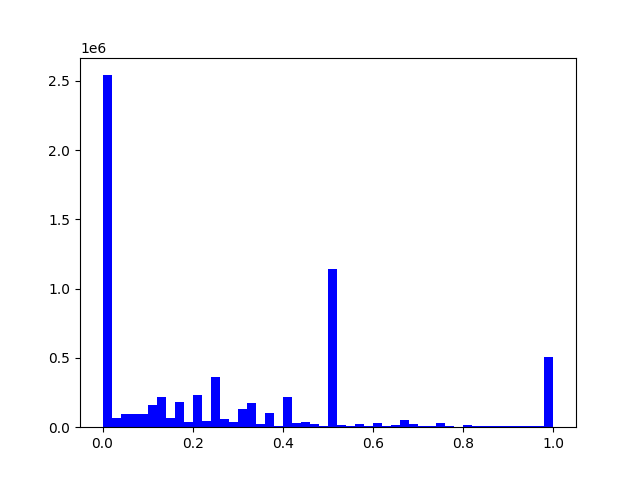

In [18]:
%matplot plt